### **Import Libraries**

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path
import torch
from torch import nn
from torch import optim

### **Create Dataset**


In [25]:
X, y = make_moons(n_samples=1000, # Make two interleaving half circles.
                  noise=None,
                  random_state=42)
X[:5], y[:5]

(array([[ 0.00872719,  0.36817352],
        [ 0.921384  , -0.49690497],
        [ 0.94022577, -0.49821192],
        [ 0.46587532, -0.34540571],
        [-0.85041204,  0.52611726]]),
 array([1, 1, 1, 1, 0]))

### **Turn Dataset into Tensors**

In [26]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
# Check
type(X), type(y)

(torch.Tensor, torch.Tensor)

### **Check Input/Output Shape**

In [27]:
print(f'Input Data Shape: {X.shape} | Input Sample Shape: {X[0].shape}')
print(f'Output Data Shape: {y.shape} | Output Sample Shape: {y[0].shape}')

Input Data Shape: torch.Size([1000, 2]) | Input Sample Shape: torch.Size([2])
Output Data Shape: torch.Size([1000]) | Output Sample Shape: torch.Size([])


### **Split Dataset into Train and Test Sets**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
# Checking
print(f'The number of Train Data: {len(X_train)}')
print(f'The Number of Test Data: {len(X_test)}')

The number of Train Data: 800
The Number of Test Data: 200


### **Visualize Datasets**

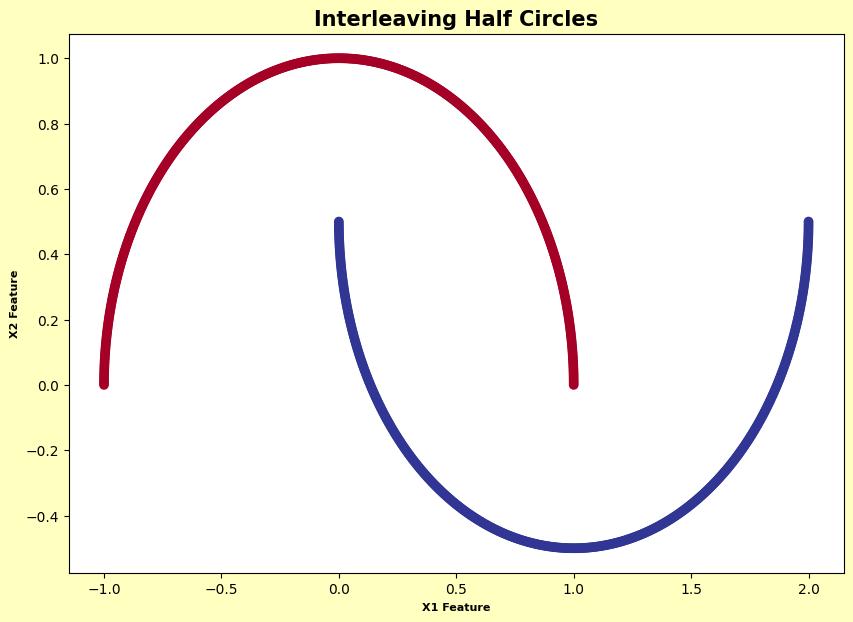

In [29]:
plt.figure(figsize=(10,7), facecolor='#ffffbf')
plt.xlabel('X1 Feature', size=8, weight='bold', color='k')
plt.ylabel('X2 Feature', size=8, weight='bold', color='k')
plt.title('Interleaving Half Circles', size=15, weight='bold', color='k')
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdYlBu')
plt.show()

### **Make Device Agnostic Code**

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### **Put Datasets into device**

In [31]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### **Model Architecturing**

In [32]:
class MoonModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.stacked_layer = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    ).to(device)
  def forward(self, x):
    return self.stacked_layer(x)

### **Create an Instance of a Model**

In [33]:
model = MoonModel(input_features=2,
                  output_features=1,
                  hidden_units=7).to(device)
model

MoonModel(
  (stacked_layer): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=7, bias=True)
    (5): ReLU()
    (6): Linear(in_features=7, out_features=1, bias=True)
  )
)

### **Define Loss Function, Accuracy Function and Optimizer**

In [34]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model.parameters(),
                       lr=0.01)
def accuracy_function(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc= correct/len(y_pred) *100
  return acc

### **Training and Test Loops**

In [38]:
# Set Manual Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put datasets into Target Device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Epochs
epochs = 100

# Count Values
epoch_count = []
loss_count = []
acc_count = []
test_loss_count = []
test_acc_count = []

#Loop
for epoch in range(epochs):
  # Training
  model.train()
  # Forward Pass
  y_logits = model(X_train).squeeze()
  y_pred_probs = torch.sigmoid(y_logits)
  y_preds = torch.round(y_pred_probs)
  # Calculate the Loss
  loss = loss_function(y_logits, y_train)
  acc = accuracy_function(y_true=y_train,
                          y_pred = y_preds)
  # Zero Gradient
  optimizer.zero_grad()
  # Backward
  loss.backward()
  # Optimizing Step by Step
  optimizer.step()

  # Test
  model.eval()
  # Forward Pass
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred_probs = torch.sigmoid(test_logits)
    test_preds = torch.round(test_pred_probs)
  # Calculate Loss/Acc
  test_loss = loss_function(test_logits, y_test)
  test_acc = accuracy_function(y_true=y_test,
                               y_pred= test_preds)
  # What's Happening?!
  if epoch % 10 ==0:
    epoch_count.append(epoch)
    loss_count.append(loss.detach().numpy())
    acc_count.append(acc)
    test_loss_count.append(test_loss.detach().numpy())
    test_acc_count.append(test_acc)
    print(f'Epoch: {epoch} | Loss: {loss} | Acc: {acc} | Test Loss: {test_loss} | Test Acc: {test_acc}')

Epoch: 0 | Loss: 0.6837977766990662 | Acc: 76.75 | Test Loss: 0.6814357042312622 | Test Acc: 85.5
Epoch: 10 | Loss: 0.6477063894271851 | Acc: 84.5 | Test Loss: 0.6457078456878662 | Test Acc: 85.0
Epoch: 20 | Loss: 0.5693509578704834 | Acc: 85.125 | Test Loss: 0.5655263066291809 | Test Acc: 85.5
Epoch: 30 | Loss: 0.4195568561553955 | Acc: 85.125 | Test Loss: 0.4160878658294678 | Test Acc: 86.5
Epoch: 40 | Loss: 0.286144882440567 | Acc: 87.25 | Test Loss: 0.28238236904144287 | Test Acc: 90.0
Epoch: 50 | Loss: 0.2181260734796524 | Acc: 90.25 | Test Loss: 0.2146386355161667 | Test Acc: 92.0
Epoch: 60 | Loss: 0.1741228550672531 | Acc: 92.375 | Test Loss: 0.16964209079742432 | Test Acc: 92.0
Epoch: 70 | Loss: 0.12702564895153046 | Acc: 94.625 | Test Loss: 0.12236636132001877 | Test Acc: 95.5
Epoch: 80 | Loss: 0.07228618860244751 | Acc: 98.375 | Test Loss: 0.06676652282476425 | Test Acc: 98.0
Epoch: 90 | Loss: 0.03099203109741211 | Acc: 100.0 | Test Loss: 0.026837997138500214 | Test Acc: 100.

### **Visualize Loss/Acc Changes**

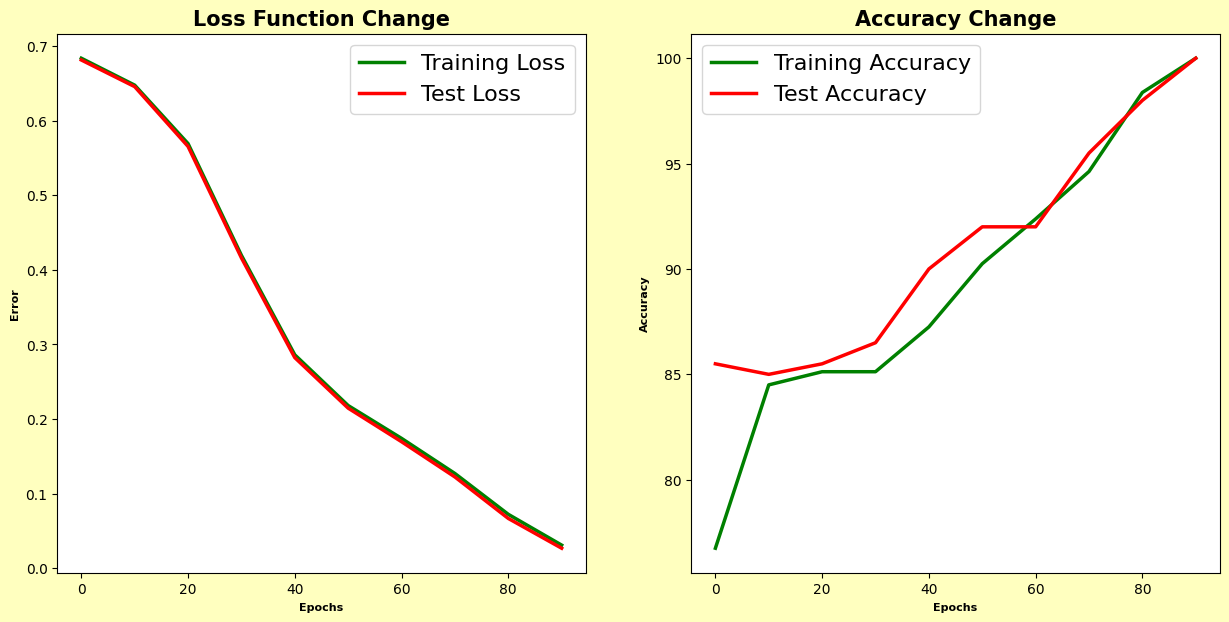

In [42]:
plt.figure(figsize=(15,7), facecolor='#ffffbf')
# Loss Change
plt.subplot(1,2,1)
plt.xlabel('Epochs', size=8, weight='bold', color='k')
plt.ylabel('Error', size=8, weight='bold', color='k')
plt.title('Loss Function Change', size=15, weight='bold', color='k')
plt.plot(epoch_count, loss_count, color='g', linewidth=2.5, label='Training Loss')
plt.plot(epoch_count, test_loss_count, color='r', linewidth=2.5, label='Test Loss')
plt.legend(prop={'size':16})
# Accuracy Change
plt.subplot(1,2,2)
plt.xlabel('Epochs', size=8, weight='bold', color='k')
plt.ylabel('Accuracy', size=8, weight='bold', color='k')
plt.title('Accuracy Change', size=15, weight='bold', color='k')
plt.plot(epoch_count, acc_count, color='g', linewidth=2.5, label='Training Accuracy')
plt.plot(epoch_count, test_acc_count, color='r', linewidth=2.5, label='Test Accuracy')
plt.legend(prop={'size':16})
plt.show()

### **Parameters of Trained Model**

In [43]:
model.state_dict()

OrderedDict([('stacked_layer.0.weight',
              tensor([[ 1.6454,  0.3166],
                      [-0.2233,  1.0115],
                      [ 0.6330, -0.0854],
                      [-0.5123,  0.7485],
                      [ 1.0144, -0.9197],
                      [ 0.9629, -0.0766],
                      [ 1.5557,  0.2233]])),
             ('stacked_layer.0.bias',
              tensor([ 0.0336,  0.3105,  1.1589,  0.7577, -0.8777,  0.9704, -0.1024])),
             ('stacked_layer.2.weight',
              tensor([[-0.0909, -0.1008,  0.7033, -0.4371,  0.6466,  0.5212, -1.2520],
                      [-0.0638, -0.4787,  1.0017, -0.3461,  0.9939,  0.7452, -1.0492],
                      [ 0.5692, -0.0738,  0.6481, -0.0316,  0.4692,  0.7543,  0.5088],
                      [ 0.4815,  0.3359, -0.5487, -1.0091,  1.1778, -0.0545,  1.0227],
                      [-0.2304, -0.3742, -0.1460, -0.2899,  0.3101,  0.1089,  0.1566],
                      [ 0.0398, -0.0849,  0.2161, -0.3272, -0.

In [44]:
print("Model Parameters:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

Model Parameters:
stacked_layer.0.weight: tensor([[ 1.6454,  0.3166],
        [-0.2233,  1.0115],
        [ 0.6330, -0.0854],
        [-0.5123,  0.7485],
        [ 1.0144, -0.9197],
        [ 0.9629, -0.0766],
        [ 1.5557,  0.2233]])
stacked_layer.0.bias: tensor([ 0.0336,  0.3105,  1.1589,  0.7577, -0.8777,  0.9704, -0.1024])
stacked_layer.2.weight: tensor([[-0.0909, -0.1008,  0.7033, -0.4371,  0.6466,  0.5212, -1.2520],
        [-0.0638, -0.4787,  1.0017, -0.3461,  0.9939,  0.7452, -1.0492],
        [ 0.5692, -0.0738,  0.6481, -0.0316,  0.4692,  0.7543,  0.5088],
        [ 0.4815,  0.3359, -0.5487, -1.0091,  1.1778, -0.0545,  1.0227],
        [-0.2304, -0.3742, -0.1460, -0.2899,  0.3101,  0.1089,  0.1566],
        [ 0.0398, -0.0849,  0.2161, -0.3272, -0.0558, -0.3377,  0.0369],
        [ 0.5063,  0.6191,  0.2268,  0.8881, -0.6579, -0.0544,  0.7771]])
stacked_layer.2.bias: tensor([ 0.6745,  0.6785,  0.7717, -1.0820, -0.3749, -0.3753,  0.2471])
stacked_layer.4.weight: tensor([[ 8.9

### **Make Predictions**

In [45]:
model.eval()
with torch.inference_mode():
  new_test_logits = model(X_test).squeeze()
  new_test_pred_probs = torch.sigmoid(new_test_logits)
  new_test_preds = torch.round(new_test_pred_probs)
new_test_loss = loss_function(new_test_logits, y_test)
new_test_acc = accuracy_function(y_true=y_test,
                                 y_pred=new_test_preds)
print(f' Test Loss Value:{new_test_loss} | Test Accuracy Value: {new_test_acc}')

 Test Loss Value:0.012011924758553505 | Test Accuracy Value: 100.0


In [46]:
new_test_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### **Import From `helper_functions.py` to Visualize**

In [48]:
if Path('helper_functions.py').is_file():
  print('The "helper_functions.py" already exists')
else:
  print('"helper_functions.py" is downloading ..')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

"helper_functions.py" is downloading ..


### **Visualize Predictions**


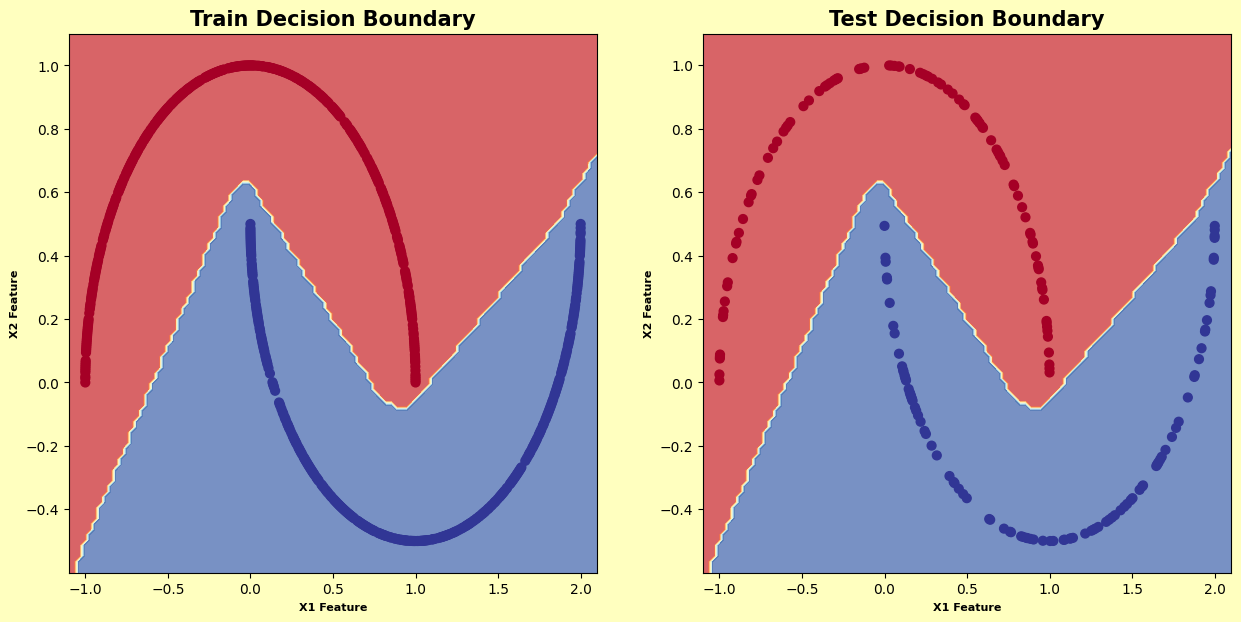

In [53]:
plt.figure(figsize=(15,7), facecolor='#ffffbf')
plt.subplot(1,2,1)
plt.xlabel('X1 Feature', size=8, weight='bold', color='k')
plt.ylabel('X2 Feature', size=8, weight='bold', color='k')
plt.title('Train Decision Boundary', size=15, weight='bold', color='k')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.xlabel('X1 Feature', size=8, weight='bold', color='k')
plt.ylabel('X2 Feature', size=8, weight='bold', color='k')
plt.title('Test Decision Boundary', size=15, weight='bold', color='k')
plot_decision_boundary(model, X_test, y_test)
plt.show()

### **Save Model**

In [55]:
# Model Path
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)
# Model Name
model_name = 'MoonModel.pth'
# Save Path
model_save_path = model_path / model_name
torch.save(obj=model.state_dict(),
           f =model_save_path)

### **Load Model**

In [56]:
loaded_model = MoonModel(input_features=2,
                         output_features=1,
                         hidden_units=7)
loaded_model.load_state_dict(torch.load(f=model_save_path))
loaded_model

<ipython-input-56-b8fb96690d29>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=model_save_path))


MoonModel(
  (stacked_layer): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=7, bias=True)
    (5): ReLU()
    (6): Linear(in_features=7, out_features=1, bias=True)
  )
)

In [57]:
loaded_model.state_dict()

OrderedDict([('stacked_layer.0.weight',
              tensor([[ 1.6454,  0.3166],
                      [-0.2233,  1.0115],
                      [ 0.6330, -0.0854],
                      [-0.5123,  0.7485],
                      [ 1.0144, -0.9197],
                      [ 0.9629, -0.0766],
                      [ 1.5557,  0.2233]])),
             ('stacked_layer.0.bias',
              tensor([ 0.0336,  0.3105,  1.1589,  0.7577, -0.8777,  0.9704, -0.1024])),
             ('stacked_layer.2.weight',
              tensor([[-0.0909, -0.1008,  0.7033, -0.4371,  0.6466,  0.5212, -1.2520],
                      [-0.0638, -0.4787,  1.0017, -0.3461,  0.9939,  0.7452, -1.0492],
                      [ 0.5692, -0.0738,  0.6481, -0.0316,  0.4692,  0.7543,  0.5088],
                      [ 0.4815,  0.3359, -0.5487, -1.0091,  1.1778, -0.0545,  1.0227],
                      [-0.2304, -0.3742, -0.1460, -0.2899,  0.3101,  0.1089,  0.1566],
                      [ 0.0398, -0.0849,  0.2161, -0.3272, -0.

### **Make Predictions with Loaded Model**

In [59]:
loaded_model.eval()
with torch.inference_mode():
  loaded_logits = loaded_model(X_test).squeeze()
  loaded_pred_probs = torch.sigmoid(loaded_logits)
  loaded_preds = torch.round(loaded_pred_probs)
loaded_loss = loss_function(loaded_logits, y_test)
loaded_acc = accuracy_function(y_test,
                      loaded_preds)
print(f' Loss Function of Loaded Model: {loaded_loss}')
print(f'Accuracy of Loaded Model: {loaded_acc}')

 Loss Function of Loaded Model: 0.012011924758553505
Accuracy of Loaded Model: 100.0
